In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation,concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
from tensorflow.keras.utils import plot_model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images = []
masks = []

In [3]:
os.chdir("images")

In [4]:
for image_name in os.listdir():
    image=cv2.imread(image_name)
    image=cv2.resize(image,(256,128))
    images.append(image)
    mask=cv2.imread(f"../binary_masks/mask{image_name[4:]}")
    mask=cv2.resize(mask,(256,128))[:, :, 0]
    mask=mask.reshape(mask.shape+(1,))
    masks.append(mask)
    

In [5]:
os.chdir('../run1/images')

In [6]:
!pwd

/home/summer_20/gaurav/lane/run1/images


In [7]:
for image_name in os.listdir():
    image=cv2.imread(image_name)
    image=cv2.resize(image,(256,128))
    images.append(image)
    mask=cv2.imread(f"../binary_masks/left{image_name[4:]}")
    mask=cv2.resize(mask,(256,128))[:, :, 0]
    mask=mask.reshape(mask.shape+(1,))
    masks.append(mask)

In [8]:
len(images)

148

In [9]:
images=np.array(images)
masks=np.array(masks)
images=images/255
masks=masks/255

In [10]:
def res_bloc(x,filters,size):
    conv=Conv2D(filters,size,activation='relu',padding='same')(x)
    conv=Conv2D(filters,size,activation='relu',padding='same')(conv)
    conv=Conv2D(filters,size,activation='relu',padding='same')(conv)
    skip=Conv2D(filters,(1,1),padding='same')(x)
    out=tf.keras.layers.add([conv,skip])
    out=Activation('relu')(out)
    return out


In [11]:
def attn(x,g,channels):
    theta_x=Conv2D(channels,(1,1),strides=(2,2),padding='same')(x)
    phi_g=Conv2D(channels,(1,1),padding='same')(g)
    xg=tf.keras.layers.Add()([theta_x, phi_g]) 
    xg=Activation('relu')(xg)
    psi=Conv2D(1,(1,1),padding='same')(xg)
    sig_xg=Activation('sigmoid')(psi)
    up=UpSampling2D((2,2))(sig_xg)
    out=tf.keras.layers.multiply([up,x])
    return out

In [12]:
def unet(input_shape):
    inputs=Input(input_shape)
    
    d1=res_bloc(inputs,32,(3,3))
    d2=MaxPooling2D((2,2))(d1)
    d2=res_bloc(d2,64,(3,3))
    d3=MaxPooling2D((2,2))(d2)
    d3=res_bloc(d3,128,(3,3))
    bn=MaxPooling2D((2,2))(d3)
    
    bn=res_bloc(bn,256,(3,3))
    
    u3=UpSampling2D((2,2))(bn)
    skip = attn(d3,bn,256)
    u3=concatenate([u3,skip])
    u3=res_bloc(u3,128,(3,3))
    u2=UpSampling2D((2,2))(u3)
    skip=attn(d2,u3,128)
    u2=concatenate([u2,skip])
    u2=res_bloc(u2,64,(3,3))
    u1=UpSampling2D((2,2))(u2)
    skip=attn(d1,u2,64)
    u1=concatenate([u1,d1])
    u1=res_bloc(u1,64,(3,3))
    
    outputs=Conv2D(1,(1,1),activation='sigmoid',padding='same')(u1)
    
    model=Model(inputs,outputs)
    return model


In [13]:
blah=(128,256,3)
model=unet(blah)

2023-09-19 17:57:25.250719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 17:57:25.265366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 17:57:25.265530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 17:57:25.266196: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 32, 64, 256)  0           ['activation_3[0][0]']           
                                                                                                  
 multiply (Multiply)            (None, 32, 64, 128)  0           ['up_sampling2d_1[0][0]',        
                                                                  'activation_2[0][0]']           
                                                                                                  
 concatenate (Concatenate)      (None, 32, 64, 384)  0           ['up_sampling2d[0][0]',          
                                                                  'multiply[0][0]']               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 64, 128)  442496      ['concatenate[0][0]']            
          

 conv2d_37 (Conv2D)             (None, 128, 256, 1)  65          ['activation_12[0][0]']          
                                                                                                  
Total params: 3,243,011
Trainable params: 3,243,011
Non-trainable params: 0
__________________________________________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(images, masks,epochs=10,batch_size=8)

Epoch 1/10
19/19 [==============================] - 2s 68ms/step - loss: 0.0714 - accuracy: 0.9886
Epoch 2/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0216 - accuracy: 0.9916
Epoch 3/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0164 - accuracy: 0.9934
Epoch 4/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0129 - accuracy: 0.9947
Epoch 5/10
19/19 [==============================] - 1s 68ms/step - loss: 0.0112 - accuracy: 0.9952
Epoch 6/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0106 - accuracy: 0.9953
Epoch 7/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0101 - accuracy: 0.9954
Epoch 8/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0101 - accuracy: 0.9954
Epoch 9/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0095 - accuracy: 0.9955
Epoch 10/10
19/19 [==============================] - 1s 67ms/step - loss: 0.0096 - accuracy: 0.9955


In [19]:
model.evaluate(images,masks)

5/5 [==============================] - 3s 340ms/step - loss: 0.0088 - accuracy: 0.9957


[0.008783329278230667, 0.9956809282302856]

In [20]:
predictions = model.predict(images)

In [21]:
predictions[0]

array([[[3.8965368e-08],
        [2.1234323e-13],
        [1.1249136e-15],
        ...,
        [1.4423420e-15],
        [1.0550705e-12],
        [4.3272965e-11]],

       [[2.2510642e-19],
        [2.7540504e-23],
        [3.8512226e-26],
        ...,
        [3.3973685e-27],
        [2.6799820e-21],
        [4.3517612e-16]],

       [[3.1011004e-20],
        [1.0244876e-23],
        [1.2760291e-27],
        ...,
        [1.7539303e-30],
        [7.1820874e-26],
        [3.7381290e-21]],

       ...,

       [[2.1282334e-03],
        [4.7834060e-04],
        [8.1589780e-05],
        ...,
        [2.4078606e-02],
        [4.5840777e-02],
        [6.0520038e-02]],

       [[6.1589465e-03],
        [2.9120315e-03],
        [3.4967603e-04],
        ...,
        [3.7287764e-02],
        [5.3317506e-02],
        [4.0888544e-02]],

       [[3.0213244e-02],
        [4.9172300e-03],
        [1.2195540e-03],
        ...,
        [1.4097388e-01],
        [1.1225354e-01],
        [1.5957057e-01]]

In [36]:
import matplotlib.pyplot as plt

In [37]:
test=test.astype(np.int32)

In [38]:
test[test < 125] = 0
test[test >= 125] = 255

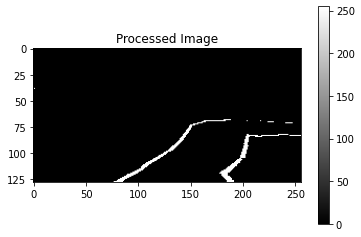

In [39]:
plt.imshow(test, cmap='gray')
plt.colorbar()
plt.title('Processed Image')
plt.show()

In [136]:
val=cv2.imread('/home/summer_20/gaurav/lane/zed1/images/86.png')
val=cv2.resize(val,(256,128))
val=val/255

In [137]:
val = val.reshape((1,)+val.shape)

In [138]:
val.shape

(1, 128, 256, 3)

In [139]:
pred=model.predict(val)

In [ ]:
pred[pred < 125] = 0
pred[pred >= 125] = 255

In [107]:
mask_image = lambda r: model.predict(images[r].reshape((1,)+images[r].shape))

In [124]:
pred = mask_image(123)

In [140]:
pred=pred*255
pred=pred.astype(np.uint32)

In [141]:
pred[pred < 125] = 0
pred[pred >= 125] = 255

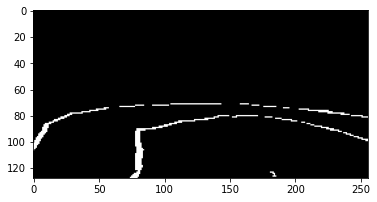

In [142]:
plt.imshow(pred.reshape((128, 256)), cmap="gray")

In [71]:
pred.min()

0

In [72]:
pred.max()

255

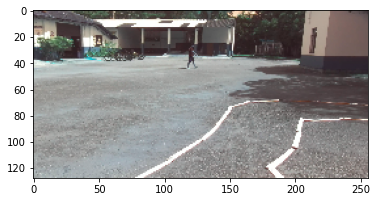

In [84]:
plt.imshow(images[72])

In [85]:
images[72].shape

(128, 256, 3)

In [154]:
pred=pred.reshape((128,256))
final = np.zeros(pred.shape+(3,))
final[:,:,0] = pred
final[:,:,1] = pred
final[:,:,2] = pred

In [155]:
final.shape

(128, 256, 3)

In [161]:
pred_=cv2.resize(final, (2208, 1242))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


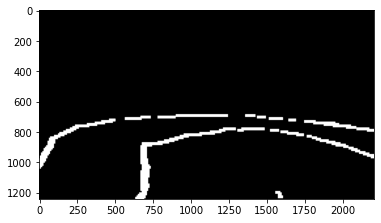

In [162]:
plt.imshow(pred_)

In [167]:
model.save("/home/summer_20/gaurav/lane/models/unet.h5")